# Combining Super-Resolution DDPM and Image Generation DDPM (CASCADED SUPER-RESOLUTION DDPM) for High-Quality Medical Image Synthesis

This notebook demonstrates the end-to-end pipeline for generating high-quality medical images using Denoising Diffusion Probabilistic Models (DDPMs) with super-resolution techniques. The pipeline combines three stages: a base DDPM trained to generate 64x64 pixel images, a Super-Resolution DDPM (SR-DDPM) that scales these images up to 128x128 pixels, and a final SR-DDPM that upscales the images further to 256x256 pixels. Each DDPM model is integrated with a UNet architecture, incorporating attention mechanisms  and the Swin Transformer, to improve the generated images' quality and fidelity. The notebook walks through loading pre-trained models, generating images at each resolution stage, and saving the outputs for evaluation and further processing.
Additionally, the notebook includes a comparison with a Super-Resolution DDPM that does not use the Swin Transformer and a 256x256 DDPM, highlighting the differences in image quality and performance across different approaches.


### SR DDPM with SWIN Transformer (PROPOSED ARCHITECTURE)

##### 1. Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
import numpy as np
import math


##### 2. Implementing Swin Transformer and Helper Functions

In [2]:
"""
Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
<https://arxiv.org/abs/2103.14030>
https://github.com/microsoft/Swin-Transformer
"""

# DropPath (Stochastic Depth) module to implement drop path regularization
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        output = x.div(keep_prob) * random_tensor
        return output

# Helper functions to handle tuple and truncation
def to_2tuple(x):
    if isinstance(x, (tuple, list)):
        return x
    return (x, x)

def trunc_normal_(tensor, mean=0., std=1.):
    with torch.no_grad():
        size = tensor.shape
        tmp = tensor.new_empty(size + (4,)).normal_()
        valid = (tmp < 2) & (tmp > -2)
        ind = valid.max(-1, keepdim=True)[1]
        tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
        tensor.data.mul_(std).add_(mean)
        return tensor

# MLP module used within Swin Transformer
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# Functions to partition and reverse windows in the Swin Transformer
def window_partition(x, window_size):
    B, C, H, W = x.shape
    x = x.view(B, C, H // window_size, window_size, W // window_size, window_size)
    windows = x.permute(0, 2, 4, 3, 5, 1).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 5, 1, 3, 2, 4).contiguous().view(B, -1, H, W)
    return x

# Window-based multi-head self-attention (W-MSA) module
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # Relative position bias table for all windows
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))

        # Get relative position index for each window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij'))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1)
        attn = attn + relative_position_bias.unsqueeze(0).to(attn.dtype)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

# Swin Transformer block implementing the shifted window-based attention mechanism
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * self.mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, out_features=dim, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size).view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x):
        B, L, C = x.shape
        H, W = self.input_resolution

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        if self.attn_mask is not None:
            attn_windows = self.attn(x_windows, mask=self.attn_mask.to(x.dtype))
        else:
            attn_windows = self.attn(x_windows)

        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        x = x.view(B, H * W, C)

        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


##### 3. Implementing the Attention Mechanisms and Sinusoidal Positional Embedding

In [3]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttentionBlock, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

class CrossAttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(CrossAttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000):
        super(SinusoidalPositionalEmbedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.max_len = max_len

    def forward(self, timesteps):
        half_dim = self.embedding_dim // 2
        emb = math.log(self.max_len) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if self.embedding_dim % 2 == 1:
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
        return emb




##### 4. Implementing the 64x64 Image Generator Unet Model

In [4]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=128):
        super(AttentionUNet, self).__init__()

        self.encoder1 = self.conv_block(in_channels + emb_dim, 64)
        self.self_attention1 = SelfAttentionBlock(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.encoder2 = self.conv_block(64, 128)
        self.self_attention2 = SelfAttentionBlock(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.encoder3 = self.conv_block(128, 256)
        self.self_attention3 = SelfAttentionBlock(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.bottleneck = self.conv_block(256, 512)
        self.swin_block = SwinTransformerBlock(dim=512, input_resolution=(8, 8), num_heads=8, window_size=4)  

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.cross_attention3 = CrossAttentionBlock(256, 256, 128)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.cross_attention2 = CrossAttentionBlock(128, 128, 64)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.cross_attention1 = CrossAttentionBlock(64, 64, 32)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.timestep_embedding_layer = SinusoidalPositionalEmbedding(emb_dim)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        t_embed = self.timestep_embedding_layer(t)
        t_embed = t_embed.view(t.size(0), -1, 1, 1)
        t_embed = t_embed.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat((x, t_embed), dim=1)

        # Encoder
        enc1 = self.encoder1(x)
        enc1 = self.self_attention1(enc1)
        enc1_pooled = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pooled)
        enc2 = self.self_attention2(enc2)
        enc2_pooled = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pooled)
        enc3 = self.self_attention3(enc3)
        enc3_pooled = self.pool3(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc3_pooled)
        B, C, H, W = bottleneck.shape
        bottleneck = bottleneck.view(B, H * W, C)
        bottleneck = self.swin_block(bottleneck)
        bottleneck = bottleneck.view(B, C, H, W)

        # Decoder
        upconv3 = self.upconv3(bottleneck)
        enc3 = self.cross_attention3(upconv3, enc3)
        dec3 = torch.cat((upconv3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        upconv2 = self.upconv2(dec3)
        enc2 = self.cross_attention2(upconv2, enc2)
        dec2 = torch.cat((upconv2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        upconv1 = self.upconv1(dec2)
        enc1 = self.cross_attention1(upconv1, enc1)
        dec1 = torch.cat((upconv1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        final_output = self.final_conv(dec1)
        return final_output


##### 5. Implementing the 64x64 to 128x128 Image Upscaling Unet Model

In [5]:

# Define the UNet model with attention
class SuperResUNet128(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=128):
        super(SuperResUNet128, self).__init__()

        self.encoder1 = self.conv_block(in_channels + emb_dim, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.bottleneck = self.conv_block(256, 512)
        self.swin_block = SwinTransformerBlock(dim=512, input_resolution=(16, 16), num_heads=8, window_size=4)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.timestep_embedding_layer = SinusoidalPositionalEmbedding(emb_dim)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        t_embed = self.timestep_embedding_layer(t)
        t_embed = t_embed.view(t.size(0), -1, 1, 1)
        t_embed = t_embed.repeat(1, 1, x.size(2), x.size(3))

        x = torch.cat((x, t_embed), dim=1)

        # Encoder
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc3_pooled)
        B, C, H, W = bottleneck.shape
        bottleneck = bottleneck.view(B, H * W, C)
        bottleneck = self.swin_block(bottleneck)
        bottleneck = bottleneck.view(B, C, H, W)

        # Decoder
        upconv3 = self.upconv3(bottleneck)
        dec3 = torch.cat((upconv3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        upconv2 = self.upconv2(dec3)
        dec2 = torch.cat((upconv2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        upconv1 = self.upconv1(dec2)
        dec1 = torch.cat((upconv1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        final_output = self.final_conv(dec1)
        return final_output


##### 6. Implementing the 128x128 to 256x256 Image Upscaling UNet Model

In [6]:

class SuperResUNet256(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=128):
        super(SuperResUNet256, self).__init__()

        self.encoder1 = self.conv_block(in_channels + emb_dim, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.bottleneck = self.conv_block(256, 512)
        self.swin_block = SwinTransformerBlock(dim=512, input_resolution=(32, 32), num_heads=8, window_size=4)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.timestep_embedding_layer = SinusoidalPositionalEmbedding(emb_dim)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        t_embed = self.timestep_embedding_layer(t)
        t_embed = t_embed.view(t.size(0), -1, 1, 1)
        t_embed = t_embed.repeat(1, 1, x.size(2), x.size(3))

        x = torch.cat((x, t_embed), dim=1)

        # Encoder
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc3_pooled)
        B, C, H, W = bottleneck.shape
        bottleneck = bottleneck.view(B, H * W, C)
        bottleneck = self.swin_block(bottleneck)
        bottleneck = bottleneck.view(B, C, H, W)

        # Decoder
        upconv3 = self.upconv3(bottleneck)
        dec3 = torch.cat((upconv3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        upconv2 = self.upconv2(dec3)
        dec2 = torch.cat((upconv2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        upconv1 = self.upconv1(dec2)
        dec1 = torch.cat((upconv1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        final_output = self.final_conv(dec1)
        return final_output


##### 7. Implementing the SR DDPM Model

In [7]:
"""
DDPM implementation adapted from:
https://github.com/hojonathanho/diffusion/tree/master
"""
class SuperResDDPM(nn.Module):
    def __init__(self, model, num_timesteps, beta_start=0.00085, beta_end=0.0120):
        super(SuperResDDPM, self).__init__()
        self.model = model
        self.num_timesteps = num_timesteps

        betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', 1 - betas)
        self.register_buffer('alphas_cumprod', torch.cumprod(1 - betas, dim=0))
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(self.alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - self.alphas_cumprod))

    def forward(self, z_t, t, low_res_image):
        # Concatenate low_res_image with z_t to condition the model
        low_res_upsampled = F.interpolate(low_res_image, scale_factor=2, mode='bilinear', align_corners=False)
        return self.model(torch.cat([z_t, low_res_upsampled], dim=1), t)

    def sample_timesteps(self, batch_size):
        return torch.randint(0, self.num_timesteps, (batch_size,)).to(device)

    def forward_diffusion(self, target_high_res_img, t, noise):
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        return sqrt_alphas_cumprod_t * target_high_res_img + sqrt_one_minus_alphas_cumprod_t * noise

    def p_losses(self, input_low_res_img, target_high_res_img, t):
        sqrt_alpha_t = self.sqrt_alphas_cumprod[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        sqrt_one_minus_alpha_t = self.sqrt_one_minus_alphas_cumprod[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)

        #input_high_res_img = F.interpolate(input_low_res_img, scale_factor=2, mode='bilinear', align_corners=False)

        noise = torch.randn_like(target_high_res_img)
        z_t = self.forward_diffusion(target_high_res_img, t, noise)

        predicted_noise = self.forward(z_t, t, input_low_res_img)

        return nn.MSELoss()(predicted_noise, noise)

    def sample(self, low_res_image):
        z_t = torch.randn_like(F.interpolate(low_res_image, scale_factor=2, mode='bilinear', align_corners=False))

        for t in reversed(range(self.num_timesteps)):
            t_tensor = torch.tensor([t], device=z_t.device).long()
            alpha_t = self.alphas[t]
            sqrt_alpha_t = torch.sqrt(alpha_t)
            sqrt_one_minus_alpha_t = torch.sqrt(1 - self.alphas_cumprod[t])
            beta_t = self.betas[t]

            predicted_noise = self.forward(z_t, t_tensor, low_res_image)

            z_t = (z_t - (1 - self.alphas[t]) * predicted_noise / sqrt_one_minus_alpha_t) / sqrt_alpha_t

            if t > 0:
                z_t += torch.randn_like(z_t) * torch.sqrt(beta_t)

        return z_t

    def p_sample(self, z, t, low_res_image):
        alpha_t = self.alphas[t]
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - self.alphas_cumprod[t])
        beta_t = self.betas[t]
        predicted_noise = self.forward(z, t, low_res_image)

        z = (z - beta_t / sqrt_one_minus_alpha_t * predicted_noise) / sqrt_alpha_t
        return z

##### 8. Implementing the 64x64 Image Generator DDPM Model

In [8]:
"""
DDPM implementation adapted from:
https://github.com/hojonathanho/diffusion/tree/master
"""
class DDPM(nn.Module):
    def __init__(self, model, num_timesteps, latent_dim, beta_start=0.00085, beta_end=0.0120):
        super(DDPM, self).__init__()
        self.model = model
        self.num_timesteps = num_timesteps

        betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', 1 - betas)
        self.register_buffer('alphas_cumprod', torch.cumprod(1 - betas, dim=0))
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(self.alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - self.alphas_cumprod))

        self.latent_dim = latent_dim

    def forward(self, z_t, t):
        return self.model(z_t, t)

    def sample_timesteps(self, batch_size):
        return torch.randint(0, self.num_timesteps, (batch_size,)).to(device)

    def forward_diffusion(self, z_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(z_0)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        return sqrt_alphas_cumprod_t * z_0 + sqrt_one_minus_alphas_cumprod_t * noise

    def p_losses(self, z_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(z_0)
        z_t = self.forward_diffusion(z_0, t, noise)
        predicted_noise = self.forward(z_t, t)
        return nn.MSELoss()(noise, predicted_noise)

    def sample(self, shape):
        z_t = torch.randn(shape).to(device)
        for t in reversed(range(self.num_timesteps)):
            t_tensor = torch.tensor([t], device=z_t.device).long()
            alpha_t = self.alphas[t]
            sqrt_alpha_t = torch.sqrt(alpha_t)
            sqrt_one_minus_alpha_t = torch.sqrt(1 - self.alphas_cumprod[t])
            beta_t = self.betas[t]

            # Predict the noise
            predicted_noise = self.forward(z_t, t_tensor)

            # Remove the predicted noise
            z_t = (z_t - beta_t / sqrt_one_minus_alpha_t * predicted_noise) / sqrt_alpha_t

            # Add noise for non-final steps
            if t > 0:
                z_t += torch.randn_like(z_t) * torch.sqrt(beta_t)

        return z_t

    def p_sample(self, z, t):
        predicted_noise = self.forward(z, t)
        alpha_t = self.alphas[t]
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
        z = (z - predicted_noise * (1 - alpha_t) / sqrt_one_minus_alpha_t) / sqrt_alpha_t
        return z


### LOAD MODELS

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(ddpm, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    ddpm.load_state_dict(checkpoint['model_state_dict'])
    return ddpm

# Load the three models from checkpoints
def load_models():
    # Model 1: 64x64 Generation
    unet_64 = AttentionUNet(in_channels=1, out_channels=1, emb_dim=128).to(device)
    ddpm_64 = DDPM(unet_64, num_timesteps=2000, latent_dim=128).to(device)
    ddpm_64 = load_model(ddpm_64, "Model_Savepoints/swinddpm64RAW_checkpoint.pth")

    # Model 2: 64x64 to 128x128 Super-resolution
    unet_128 = SuperResUNet128(in_channels=2, out_channels=1, emb_dim=128).to(device)
    ddpm_128 = SuperResDDPM(unet_128, num_timesteps=1000).to(device)
    ddpm_128 = load_model(ddpm_128, "Model_Savepoints/cascadedddpm64200epochs_checkpoint.pth")

    # Model 3: 128x128 to 256x256 Super-resolution
    unet_256 = SuperResUNet256(in_channels=2, out_channels=1, emb_dim=128).to(device)
    ddpm_256 = SuperResDDPM(unet_256, num_timesteps=1000).to(device)
    ddpm_256 = load_model(ddpm_256, "Model_Savepoints/cascadedddpm128(225epoch)_checkpoint.pth")

    return ddpm_64, ddpm_128, ddpm_256

##### Image Generation

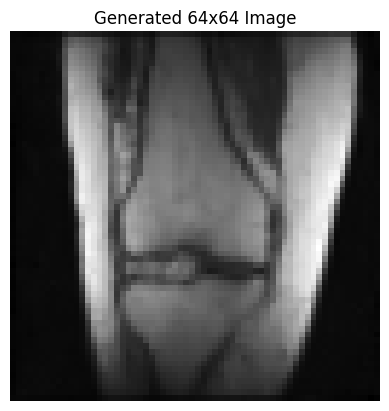

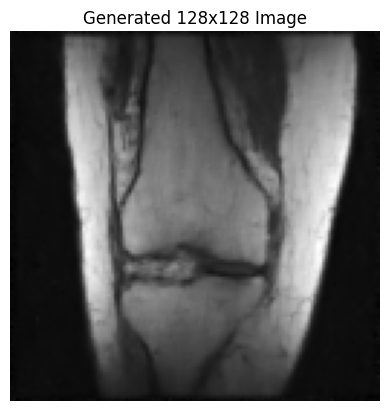

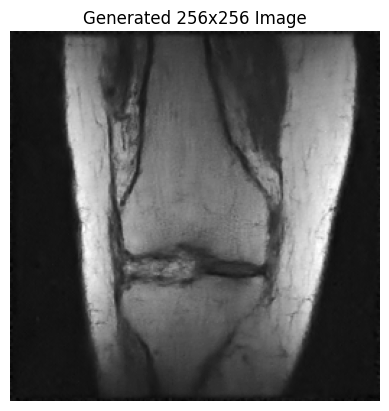

In [20]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to display generated image
def display_image(image, title='Generated Image'):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate and display a single image
def generate_and_display_image(ddpm_64, ddpm_128, ddpm_256):
    # Set models to evaluation mode
    ddpm_64.eval()
    ddpm_128.eval()
    ddpm_256.eval()

    with torch.no_grad():
        # Generate 64x64 image
        shape_64 = (1, 1, 64, 64)
        image_64 = ddpm_64.sample(shape_64)
        
        # Super-resolve to 128x128
        image_128 = ddpm_128.sample(image_64)  
        
        # Super-resolve to 256x256
        image_256 = ddpm_256.sample(image_128) 

        # Convert tensors to numpy arrays and squeeze to remove unnecessary dimensions
        image_64 = image_64.cpu().numpy().squeeze()
        image_128 = image_128.cpu().numpy().squeeze()
        image_256 = image_256.cpu().numpy().squeeze()

        # Display the images
        display_image(image_64, title='Generated 64x64 Image')
        display_image(image_128, title='Generated 128x128 Image')
        display_image(image_256, title='Generated 256x256 Image')


ddpm_64, ddpm_128, ddpm_256 = load_models()
generate_and_display_image(ddpm_64, ddpm_128, ddpm_256)


In [80]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to save generated images
def save_generated_images(images, save_dir, prefix='image', start_idx=0):
    os.makedirs(save_dir, exist_ok=True)
    for i, image in enumerate(images):
        plt.imsave(os.path.join(save_dir, f'{prefix}_{i + start_idx}.png'), image, cmap='gray')

# Generate images and save them into separate directories
def generate_and_save_images(ddpm_64, ddpm_128, ddpm_256, save_dir_64='generated_images_64', save_dir_256='generated_images_256', num_images=10):
    # Create directories if they don't exist
    os.makedirs(save_dir_64, exist_ok=True)
    os.makedirs(save_dir_256, exist_ok=True)

    # Initialize lists to store generated images
    images_64 = []
    images_128 = []
    images_256 = []

    ddpm_64.eval()
    ddpm_128.eval()
    ddpm_256.eval()

    with torch.no_grad():
        for i in range(num_images):
            # Generate 64x64 image
            shape_64 = (1, 1, 64, 64)
            image_64 = ddpm_64.sample(shape_64)
            images_64.append(image_64.cpu().numpy().squeeze())
            
            # Super-resolve to 128x128
            image_128 = ddpm_128.sample(image_64)
            images_128.append(image_128.cpu().numpy().squeeze())

            # Super-resolve to 256x256
            image_256 = ddpm_256.sample(image_128)
            images_256.append(image_256.cpu().numpy().squeeze())

            # Save 64x64 and 256x256 images in separate directories
            save_generated_images([images_64[-1]], save_dir_64, prefix=f'image_{i+1}_64x64')
            save_generated_images([images_256[-1]], save_dir_256, prefix=f'image_{i+1}_256x256')

    print(f'Images saved in {save_dir_64} and {save_dir_256}')


ddpm_64, ddpm_128, ddpm_256 = load_models()
generate_and_save_images(ddpm_64, ddpm_128, ddpm_256, save_dir_64='generated_images_SWIN64try', save_dir_256='generated_images_SWIN256try', num_images=200)


Images saved in generated_images_SWIN64try and generated_images_SWIN256try


### SR DDPM without SWIN Transformer

#####  Implementing the 64x64 Image Generator Unet Model without SWIN Transformer

In [13]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=128):
        super(AttentionUNet, self).__init__()

        self.encoder1 = self.conv_block(in_channels + emb_dim, 64)
        self.self_attention1 = SelfAttentionBlock(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.encoder2 = self.conv_block(64, 128)
        self.self_attention2 = SelfAttentionBlock(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.encoder3 = self.conv_block(128, 256)
        self.self_attention3 = SelfAttentionBlock(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.bottleneck = self.conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.cross_attention3 = CrossAttentionBlock(256, 256, 128)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.cross_attention2 = CrossAttentionBlock(128, 128, 64)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.cross_attention1 = CrossAttentionBlock(64, 64, 32)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.timestep_embedding_layer = SinusoidalPositionalEmbedding(emb_dim)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        t_embed = self.timestep_embedding_layer(t)
        t_embed = t_embed.view(t.size(0), -1, 1, 1)
        t_embed = t_embed.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat((x, t_embed), dim=1)

        # Encoder
        enc1 = self.encoder1(x)
        enc1 = self.self_attention1(enc1)
        enc1_pooled = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pooled)
        enc2 = self.self_attention2(enc2)
        enc2_pooled = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pooled)
        enc3 = self.self_attention3(enc3)
        enc3_pooled = self.pool3(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc3_pooled)

        # Decoder
        upconv3 = self.upconv3(bottleneck)
        enc3 = self.cross_attention3(upconv3, enc3)
        dec3 = torch.cat((upconv3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        upconv2 = self.upconv2(dec3)
        enc2 = self.cross_attention2(upconv2, enc2)
        dec2 = torch.cat((upconv2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        upconv1 = self.upconv1(dec2)
        enc1 = self.cross_attention1(upconv1, enc1)
        dec1 = torch.cat((upconv1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        final_output = self.final_conv(dec1)
        return final_output

##### Implementing the 64x64 to 128x128 Image Upscaling Unet Model without SWIN Transformer

In [14]:
class SuperResUNet128(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=128):
        super(SuperResUNet128, self).__init__()

        self.encoder1 = self.conv_block(in_channels + emb_dim, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.bottleneck = self.conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.timestep_embedding_layer = SinusoidalPositionalEmbedding(emb_dim)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        t_embed = self.timestep_embedding_layer(t)
        t_embed = t_embed.view(t.size(0), -1, 1, 1)
        t_embed = t_embed.repeat(1, 1, x.size(2), x.size(3))

        x = torch.cat((x, t_embed), dim=1)

        # Encoder
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc3_pooled)

        # Decoder
        upconv3 = self.upconv3(bottleneck)
        dec3 = torch.cat((upconv3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        upconv2 = self.upconv2(dec3)
        dec2 = torch.cat((upconv2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        upconv1 = self.upconv1(dec2)
        dec1 = torch.cat((upconv1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        final_output = self.final_conv(dec1)
        return final_output


##### Implementing the 128x128 to 256x256 Image Upscaling Unet Model without SWIN Transformer

In [15]:
class SuperResUNet256(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=128):
        super(SuperResUNet256, self).__init__()

        self.encoder1 = self.conv_block(in_channels + emb_dim, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.bottleneck = self.conv_block(256, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.timestep_embedding_layer = SinusoidalPositionalEmbedding(emb_dim)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        t_embed = self.timestep_embedding_layer(t)
        t_embed = t_embed.view(t.size(0), -1, 1, 1)
        t_embed = t_embed.repeat(1, 1, x.size(2), x.size(3))

        x = torch.cat((x, t_embed), dim=1)

        # Encoder
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc3_pooled)

        # Decoder
        upconv3 = self.upconv3(bottleneck)
        dec3 = torch.cat((upconv3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        upconv2 = self.upconv2(dec3)
        dec2 = torch.cat((upconv2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        upconv1 = self.upconv1(dec2)
        dec1 = torch.cat((upconv1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        final_output = self.final_conv(dec1)
        return final_output


##### LOAD Models

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(ddpm, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    ddpm.load_state_dict(checkpoint['model_state_dict'])
    return ddpm

# Load the three models from checkpoints
def load_models():
    # Model 1: 64x64 Generation
    unet_64 = AttentionUNet(in_channels=1, out_channels=1, emb_dim=128).to(device)
    ddpm_64 = DDPM(unet_64, num_timesteps=2000, latent_dim=128).to(device)
    ddpm_64 = load_model(ddpm_64, "Model_Savepoints/ddpm64NOSWIN_checkpoint.pth")

    # Model 2: 64x64 to 128x128 Super-resolution
    unet_128 = SuperResUNet128(in_channels=2, out_channels=1, emb_dim=128).to(device)
    ddpm_128 = SuperResDDPM(unet_128, num_timesteps=1000).to(device)
    ddpm_128 = load_model(ddpm_128, "Model_Savepoints/cascadedddpm64NOSWIN(100epoch)_checkpoint.pth")

    # Model 3: 128x128 to 256x256 Super-resolution
    unet_256 = SuperResUNet256(in_channels=2, out_channels=1, emb_dim=128).to(device)
    ddpm_256 = SuperResDDPM(unet_256, num_timesteps=1000).to(device)
    ddpm_256 = load_model(ddpm_256, "Model_Savepoints/cascadedddpm128NOSWIN_checkpoint.pth")

    return ddpm_64, ddpm_128, ddpm_256

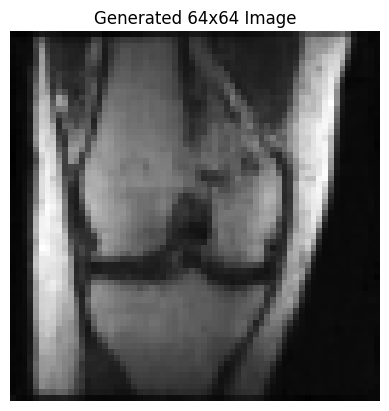

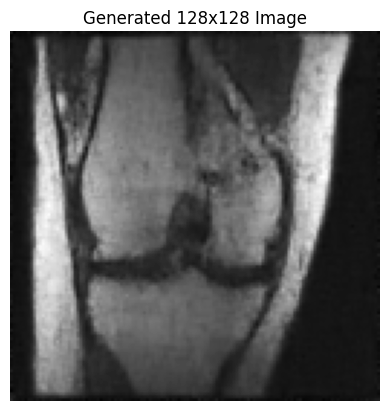

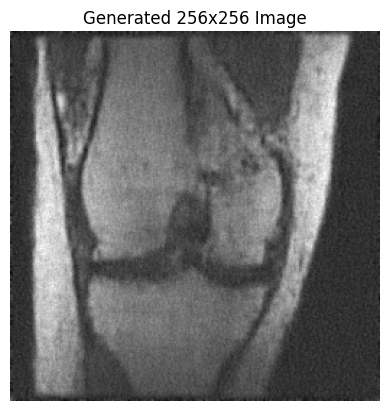

In [17]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to display generated image
def display_image(image, title='Generated Image'):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate and display a single image
def generate_and_display_image(ddpm_64, ddpm_128, ddpm_256):
    # Set models to evaluation mode
    ddpm_64.eval()
    ddpm_128.eval()
    ddpm_256.eval()

    with torch.no_grad():
        # Generate 64x64 image
        shape_64 = (1, 1, 64, 64)
        image_64 = ddpm_64.sample(shape_64)
        
        # Super-resolve to 128x128
        image_128 = ddpm_128.sample(image_64)  
        
        # Super-resolve to 256x256
        image_256 = ddpm_256.sample(image_128) 

        # Convert tensors to numpy arrays and squeeze to remove unnecessary dimensions
        image_64 = image_64.cpu().numpy().squeeze()
        image_128 = image_128.cpu().numpy().squeeze()
        image_256 = image_256.cpu().numpy().squeeze()

        # Display the images
        display_image(image_64, title='Generated 64x64 Image')
        display_image(image_128, title='Generated 128x128 Image')
        display_image(image_256, title='Generated 256x256 Image')


ddpm_64, ddpm_128, ddpm_256 = load_models()
generate_and_display_image(ddpm_64, ddpm_128, ddpm_256)


In [19]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to save generated images
def save_generated_images(images, save_dir, prefix='image', start_idx=0):
    os.makedirs(save_dir, exist_ok=True)
    for i, image in enumerate(images):
        plt.imsave(os.path.join(save_dir, f'{prefix}_{i + start_idx}.png'), image, cmap='gray')

# Generate images and save them into separate directories
def generate_and_save_images(ddpm_64, ddpm_128, ddpm_256, save_dir_64='generated_images_64', save_dir_256='generated_images_256', num_images=10):
    # Create directories if they don't exist
    os.makedirs(save_dir_64, exist_ok=True)
    os.makedirs(save_dir_256, exist_ok=True)

    # Initialize lists to store generated images
    images_64 = []
    images_128 = []
    images_256 = []

    ddpm_64.eval()
    ddpm_128.eval()
    ddpm_256.eval()

    with torch.no_grad():
        for i in range(num_images):
            # Generate 64x64 image
            shape_64 = (1, 1, 64, 64)
            image_64 = ddpm_64.sample(shape_64)
            images_64.append(image_64.cpu().numpy().squeeze())
            
            # Super-resolve to 128x128
            image_128 = ddpm_128.sample(image_64)
            images_128.append(image_128.cpu().numpy().squeeze())

            # Super-resolve to 256x256
            image_256 = ddpm_256.sample(image_128)
            images_256.append(image_256.cpu().numpy().squeeze())

            # Save 64x64 and 256x256 images in separate directories
            save_generated_images([images_64[-1]], save_dir_64, prefix=f'image_{i+1}_64x64')
            save_generated_images([images_256[-1]], save_dir_256, prefix=f'image_{i+1}_256x256')

    print(f'Images saved in {save_dir_64} and {save_dir_256}')


ddpm_64, ddpm_128, ddpm_256 = load_models()
generate_and_save_images(ddpm_64, ddpm_128, ddpm_256, save_dir_64='generated_images_NOSWIN64', save_dir_256='generated_images_NOSWIN256', num_images=200)


Images saved in generated_images_NOSWIN64 and generated_images_NOSWIN256


### 256x256 DDPM with SWIN Transformer

#####  Implementing the 256x256 Image Generator Unet Model with SWIN Transformer

In [18]:

# UNet with SWIN Transformer in bottleneck
class AttentionUNet(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=128):
        super(AttentionUNet, self).__init__()

        self.encoder1 = self.conv_block(in_channels + emb_dim, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.bottleneck = self.conv_block(256, 512)
        self.swin_block = SwinTransformerBlock(dim=512, input_resolution=(32, 32), num_heads=8, window_size=4)  

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.timestep_embedding_layer = SinusoidalPositionalEmbedding(emb_dim)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        t_embed = self.timestep_embedding_layer(t)
        t_embed = t_embed.view(t.size(0), -1, 1, 1)
        t_embed = t_embed.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat((x, t_embed), dim=1)

        # Encoder
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc3_pooled)
        B, C, H, W = bottleneck.shape
        bottleneck = bottleneck.view(B, H * W, C)
        bottleneck = self.swin_block(bottleneck)
        bottleneck = bottleneck.view(B, C, H, W)

        # Decoder
        upconv3 = self.upconv3(bottleneck)
        dec3 = torch.cat((upconv3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        upconv2 = self.upconv2(dec3)
        dec2 = torch.cat((upconv2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        upconv1 = self.upconv1(dec2)
        dec1 = torch.cat((upconv1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        final_output = self.final_conv(dec1)
        return final_output


#####  Implementing the 256x256 DDPM

In [19]:
"""
DDPM implementation adapted from:
https://github.com/hojonathanho/diffusion/tree/master
"""

class DDPM(nn.Module):
    def __init__(self, model, num_timesteps, latent_dim, beta_start=0.00085, beta_end=0.0120):
        super(DDPM, self).__init__()
        self.model = model
        self.num_timesteps = num_timesteps

        betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', 1 - betas)
        self.register_buffer('alphas_cumprod', torch.cumprod(1 - betas, dim=0))
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(self.alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - self.alphas_cumprod))

        self.latent_dim = latent_dim

    def forward(self, z_t, t):
        return self.model(z_t, t)

    def sample_timesteps(self, batch_size):
        return torch.randint(0, self.num_timesteps, (batch_size,)).to(device)

    def forward_diffusion(self, z_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(z_0)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        return sqrt_alphas_cumprod_t * z_0 + sqrt_one_minus_alphas_cumprod_t * noise

    def p_losses(self, z_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(z_0)
        z_t = self.forward_diffusion(z_0, t, noise)
        predicted_noise = self.forward(z_t, t)
        return nn.MSELoss()(noise, predicted_noise)

    def sample(self, shape):
        z_t = torch.randn(shape).to(device)
        for t in reversed(range(self.num_timesteps)):
            t_tensor = torch.tensor([t], device=z_t.device).long()
            alpha_t = self.alphas[t]
            sqrt_alpha_t = torch.sqrt(alpha_t)
            sqrt_one_minus_alpha_t = torch.sqrt(1 - self.alphas_cumprod[t])
            beta_t = self.betas[t]

            # Predict the noise
            predicted_noise = self.forward(z_t, t_tensor)

            # Remove the predicted noise
            z_t = (z_t - beta_t / sqrt_one_minus_alpha_t * predicted_noise) / sqrt_alpha_t

            # Add noise for non-final steps
            if t > 0:
                z_t += torch.randn_like(z_t) * torch.sqrt(beta_t)

        return z_t

    def p_sample(self, z, t):
        predicted_noise = self.forward(z, t)
        alpha_t = self.alphas[t]
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
        z = (z - predicted_noise * (1 - alpha_t) / sqrt_one_minus_alpha_t) / sqrt_alpha_t
        return z


##### Load Models

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(ddpm, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    ddpm.load_state_dict(checkpoint['model_state_dict'])
    return ddpm


def load_models():
    # Model 1: 64x64 Generation
    unet = AttentionUNet(in_channels=1, out_channels=1, emb_dim=128).to(device)
    ddpm = DDPM(unet, num_timesteps=2000, latent_dim=128).to(device)
    ddpm = load_model(ddpm, "DDPM_256x256/swinddpm256_MRNet_checkpoint.pth")

    return ddpm

##### Generation

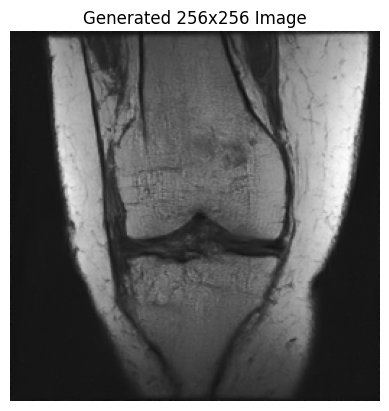

In [26]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to display generated image
def display_image(image, title='Generated Image'):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate and display a single image
def generate_and_display_image(ddpm):
    # Set models to evaluation mode
    ddpm.eval()

    with torch.no_grad():
        # Generate 64x64 image
        shape = (1, 1, 256, 256)
        image = ddpm.sample(shape)

        image = image.cpu().numpy().squeeze()

        display_image(image, title='Generated 256x256 Image')



ddpm = load_models()
generate_and_display_image(ddpm)
